## Imports 

In [33]:
import pandas as pd 
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_Imb
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from typing import Any, Dict, Union
from probatus.feature_elimination import ShapRFECV
from functools import partial
import shap 
pd.options.mode.chained_assignment = None  # default='warn'

In [34]:
X_train = pd.read_csv('X_train.csv')
X_eval = pd.read_csv('X_eval.csv')

# Model 0 : XGBOOST

In [35]:
def tweak_df(df_: pd.DataFrame) -> pd.DataFrame:
    float_columns = (df_
           .loc[:, ~df_.columns.str.contains("ID", case=False)]  
           .select_dtypes(include='float')
          ).columns.tolist()
    return df_[float_columns]

class TweakDfTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df(X)

    def fit(self, X, y=None): 
        return self

In [36]:
def get_rawX_y(df, y_col):
    return df.drop(columns=[y_col]), df[y_col]

In [37]:
X_train_1, y_train_1 = get_rawX_y(X_train, 'label')
X_eval_1, y_eval_1 = get_rawX_y(X_eval, 'label')

In [38]:
tweak_transformer = TweakDfTransformer()

In [39]:
X_train_transformed = tweak_transformer.fit_transform(X_train_1)
X_eval_transformed = tweak_transformer.transform(X_eval_1)

In [40]:
model_0 = Pipeline([
    ('xgboost', XGBClassifier())]
)

In [41]:
model_0.fit(X_train_transformed, y_train_1)
y_pred_eval_0 = model_0.predict(X_eval_transformed)

In [42]:
y_pred_train_0 = model_0.predict(X_train_transformed)

In [43]:
train_accuracy = accuracy_score(y_train_1, y_pred_train_0)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval_0)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9925
Evaluation Accuracy: 0.9758


In [14]:
def hyperparameter_tuning(
    space: Dict[str, Union[float, int]], 
    X_train: pd.DataFrame,
    y_train: pd.Series,
    kf : KFold(), 
    early_stopping_rounds: int = 50,
    n_estimators: int = 1000, 
    metric: callable = accuracy_score
) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    kf : KFold
        KFold cross-validation strategy. Default is 5 splits, random state 42, and shuffle=True.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. Default is 50.
    metric : callable
        Metric to maximize. Default is accuracy_score.

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the tuning process.
        The loss is a float, and the model is an XGBoost classifier.
    """
    # Convert integer parameters
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val) for k, val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    space['n_estimators'] = n_estimators
    
    # Initialize XGBoost model with hyperparameters
    model = xgb.XGBClassifier(**space)
    
    # Cross-validation scores
    scores = []
    
    for train_index, test_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Fit model
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        score = metric(y_val, y_pred)
        scores.append(score)
    
    # Calculate average score
    avg_score = np.mean(scores)
    
    return {'loss': -avg_score, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5)

options = {
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10),
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'random_state': 42
}

# Perform cross-validation and optimize the mean validation score
best = fmin(
    fn=lambda space: hyperparameter_tuning(
        space, X_train_transformed, y_train_1, kf
    ),
    space=options,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials
)

In [15]:
long_params = {
    'colsample_bytree': 0.6286712770557569,
    'gamma': 0.026563791342747122,
    'learning_rate': 0.026384573469837167,
    'max_depth': 7,
    'min_child_weight': 1.3490106703584013,
    'reg_alpha': 0.8548622748586215,
    'reg_lambda': 5.4399917412349375,
    'subsample': 0.6593562493558628}

xg_ex = xgb.XGBClassifier(
    **long_params,
    early_stopping_rounds=50,
    n_estimators=1000
)

xg_ex.fit(
    X_train_transformed, y_train_1,
    eval_set=[(X_train_transformed, y_train_1), (X_eval_transformed, y_eval_1)],
    verbose=100
)

print(xg_ex.score(X_eval_transformed, y_eval_1))

[0]	validation_0-mlogloss:1.07710	validation_1-mlogloss:1.07732
[100]	validation_0-mlogloss:0.17264	validation_1-mlogloss:0.17719
[200]	validation_0-mlogloss:0.08511	validation_1-mlogloss:0.09442
[300]	validation_0-mlogloss:0.06545	validation_1-mlogloss:0.07950
[400]	validation_0-mlogloss:0.05734	validation_1-mlogloss:0.07616
[500]	validation_0-mlogloss:0.05140	validation_1-mlogloss:0.07524
[589]	validation_0-mlogloss:0.04718	validation_1-mlogloss:0.07521
0.97725


In [16]:
xg_ex.feature_importances_

array([0.01398681, 0.01149964, 0.05302378, 0.0755979 , 0.03119179,
       0.03486096, 0.08259995, 0.6972393 ], dtype=float32)

<Axes: >

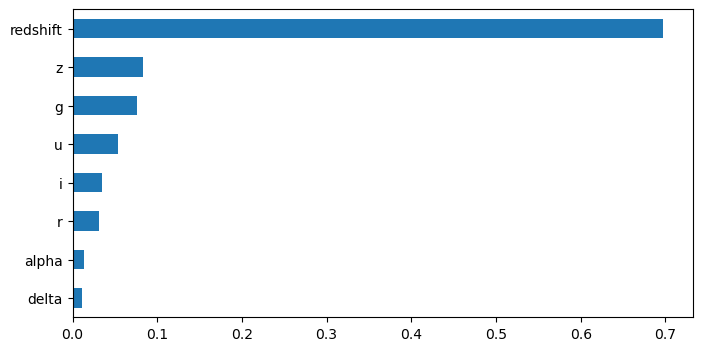

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(xg_ex.feature_importances_, index=X_train_transformed.columns)
 .sort_values()
).plot.barh(ax=ax)

In [18]:
pd.Series(xg_ex.feature_importances_, index=X_train_transformed.columns).sort_values()

delta       0.011500
alpha       0.013987
r           0.031192
i           0.034861
u           0.053024
g           0.075598
z           0.082600
redshift    0.697239
dtype: float32

In [19]:
X_train_transformed.columns.tolist()

['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

In [20]:
photometric = ['u', 'g', 'r', 'i', 'z']

In [44]:
photometric_pairs = list(itertools.combinations(photometric, 2))

def photometric_magnitude_differences(df):
    for pair in photometric_pairs:
        df[f'difference_{pair[0]}_{pair[1]}'] = df[pair[0]] - df[pair[1]]
    return df

def photometric_sum(df): 
    df['sum_photometric'] = df['u'] + df['g'] + df['r'] + df['i'] + df['z']
    return df

def photometric_std(df): 
    df['std_photometric'] = df[photometric].std(axis=1)
    return df

def photometric_max(df): 
    df['max_photometric'] = df[photometric].max(axis=1)
    return df

def photometric_min(df): 
    df['min_photometric'] = df[photometric].min(axis=1)
    return df

def normalized_redshift(df):
    # Avoid division by zero
    df['normalized_redshift'] = (df['u'] + df['g'] + df['r'] + df['i'] + df['z']) / df['redshift'].replace(0, np.nan)
    return df

def time_since_start(df):
    df['time_since_start'] = df['MJD'] - df['MJD'].min()
    return df

def photometric_interaction_effects(df): 
    for pair in photometric_pairs:
        df[f'interaction_{pair[0]}_{pair[1]}'] = df[pair[0]] * df[pair[1]]
    return df

def spectral_ratios(df):
    for pair in photometric_pairs:
        df[f'ratio_{pair[0]}_{pair[1]}'] = df[pair[0]] / df[pair[1]].replace(0, np.nan)
    return df

def angular_distances(df):
    df["angular_distance"] = np.sqrt(df["alpha"]**2 + df["delta"]**2)
    return df

# Updated new_features function
def new_features(df: pd.DataFrame) -> pd.DataFrame:
    return (df
            .pipe(photometric_magnitude_differences)
            .pipe(photometric_sum)
            .pipe(photometric_std)
            .pipe(photometric_max)
            .pipe(photometric_min)
            .pipe(normalized_redshift)
            .pipe(time_since_start)
            .pipe(photometric_interaction_effects)
            .pipe(spectral_ratios)
            .pipe(angular_distances)
           )


In [45]:
class NewFeatureTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return new_features(X)

    def fit(self, X, y=None): 
        return self

In [46]:
df_pre_2 = Pipeline([
    ('NewFeatures', NewFeatureTransformer()), 
    ('TweakDF', TweakDfTransformer())]
)

In [47]:
X_train_transformed_2 = df_pre_2.fit_transform(X_train)
X_eval_transformed_2 = df_pre_2.transform(X_eval)

In [48]:
X_train_transformed_2.columns

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'difference_u_g',
       'difference_u_r', 'difference_u_i', 'difference_u_z', 'difference_g_r',
       'difference_g_i', 'difference_g_z', 'difference_r_i', 'difference_r_z',
       'difference_i_z', 'sum_photometric', 'std_photometric',
       'max_photometric', 'min_photometric', 'normalized_redshift',
       'interaction_u_g', 'interaction_u_r', 'interaction_u_i',
       'interaction_u_z', 'interaction_g_r', 'interaction_g_i',
       'interaction_g_z', 'interaction_r_i', 'interaction_r_z',
       'interaction_i_z', 'ratio_u_g', 'ratio_u_r', 'ratio_u_i', 'ratio_u_z',
       'ratio_g_r', 'ratio_g_i', 'ratio_g_z', 'ratio_r_i', 'ratio_r_z',
       'ratio_i_z', 'angular_distance'],
      dtype='object')

In [49]:
xg_ex.fit(
    X_train_transformed_2, y_train_1,
    eval_set=[(X_train_transformed_2, y_train_1), (X_eval_transformed_2, y_eval_1)], 
    verbose = 100
)

[0]	validation_0-mlogloss:1.06614	validation_1-mlogloss:1.06626
[100]	validation_0-mlogloss:0.12336	validation_1-mlogloss:0.12873
[200]	validation_0-mlogloss:0.06084	validation_1-mlogloss:0.07233
[300]	validation_0-mlogloss:0.04844	validation_1-mlogloss:0.06585
[400]	validation_0-mlogloss:0.04006	validation_1-mlogloss:0.06417
[500]	validation_0-mlogloss:0.03368	validation_1-mlogloss:0.06400
[535]	validation_0-mlogloss:0.03186	validation_1-mlogloss:0.06398


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6286712770557569, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.026563791342747122,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.026384573469837167,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.3490106703584013, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [50]:
print(xg_ex.score(X_eval_transformed_2, y_eval_1))

0.9806666666666667


<Axes: >

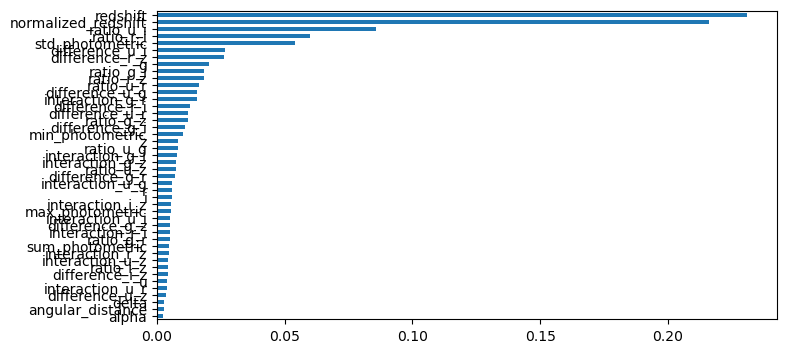

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(xg_ex.feature_importances_, index=X_train_transformed_2.columns)
 .sort_values()
).plot.barh(ax=ax)

In [ ]:
best = fmin(
    fn=lambda space: hyperparameter_tuning(
        space, X_train_transformed_2, y_train_1, kf
    ),
    space=options,
    algo=tpe.suggest,
    trials=trials,
    timeout= 8 * 60 * 60
)

### a) minimal preprocessing 

In [82]:
model_1 = Pipeline([
    ('standardise', StandardScaler()), 
    ('logisticRegression', LogisticRegression(class_weight = 'balanced', max_iter = 10000))]
)

In [83]:
model_1

Pipeline(steps=[('standardise', StandardScaler()),
                ('logisticRegression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [87]:
model_1.fit(X_train_transformed, y_train_1)
y_pred_eval = model_1.predict(X_eval_transformed)

In [88]:
y_pred_train = model_1.predict(X_train_transformed)

In [89]:
train_accuracy = accuracy_score(y_train_1, y_pred_train)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9388
Evaluation Accuracy: 0.9418


### b) Hyperparameter tuned

In [90]:
l1 = np.round(np.linspace(0.01, 0.09, 9), 2).tolist()

In [91]:
l2 = np.round(np.linspace(0.1, 0.9, 9), 2).tolist()

In [92]:
l3 = np.linspace(1, 9, 9).tolist()

In [93]:
l4 = np.linspace(10, 100, 10).tolist()

In [94]:
l = l1 + l2 + l3 + l4
l

[0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0]

In [173]:
param_grid = {
    'logisticRegression__C': l1 + l2 + l3,  
}

grid_search = GridSearchCV(
    estimator=model_1,
    param_grid=param_grid,
    cv=7,  
    scoring='accuracy', 
    n_jobs=-1, 
    verbose = 2
)

grid_search.fit(X_train_transformed, y_train_1)

best_model_1 = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 7 folds for each of 27 candidates, totalling 189 fits
Best Parameters: {'logisticRegression__C': 9.0}
[CV] END .........................logisticRegression__C=0.01; total time=   0.5s
[CV] END .........................logisticRegression__C=0.02; total time=   0.4s
[CV] END .........................logisticRegression__C=0.03; total time=   0.4s
[CV] END .........................logisticRegression__C=0.04; total time=   0.5s
[CV] END .........................logisticRegression__C=0.05; total time=   0.5s
[CV] END .........................logisticRegression__C=0.07; total time=   0.5s
[CV] END .........................logisticRegression__C=0.08; total time=   0.5s
[CV] END .........................logisticRegression__C=0.09; total time=   0.4s
[CV] END ..........................logisticRegression__C=0.1; total time=   0.6s
[CV] END ..........................logisticRegression__C=0.2; total time=   0.5s
[CV] END ..........................logisticRegression__C=0.3; total time=   0.5s

In [96]:
best_model_1.fit(X_train_transformed, y_train_1)
y_pred_eval_1 = best_model_1.predict(X_eval_transformed)
y_pred_train_1 = best_model_1.predict(X_train_transformed)

In [97]:
train_accuracy = accuracy_score(y_train_1, y_pred_train_1)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval_1)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9488
Evaluation Accuracy: 0.9523


## Model 2 : KNN 

In [98]:
model_2 = Pipeline([
    ('standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

In [99]:
model_2.fit(X_train_transformed, y_train_1)
y_pred_eval_2 = model_2.predict(X_eval_transformed)
y_pred_train_2 = model_2.predict(X_train_transformed)

In [100]:
train_accuracy = accuracy_score(y_train_1, y_pred_train_2)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval_2)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9504
Evaluation Accuracy: 0.9343


In [101]:
int_list = np.linspace(2, 50, 49).astype(int).tolist()

In [102]:
param_grid = {
    'KNN__n_neighbors': int_list,  
}

grid_search = GridSearchCV(
    estimator=model_2,
    param_grid=param_grid,
    cv=10,  
    scoring='accuracy', 
    n_jobs=-1, 
    verbose = 3
)

grid_search.fit(X_train_transformed, y_train_1)

best_model_2 = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best Parameters: {'KNN__n_neighbors': 3}


In [103]:
best_model_2.fit(X_train_transformed, y_train_1)
y_pred_eval_2 = best_model_2.predict(X_eval_transformed)
y_pred_train_2 = best_model_2.predict(X_train_transformed)

In [104]:
train_accuracy = accuracy_score(y_train_1, y_pred_train_2)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval_2)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9601
Evaluation Accuracy: 0.9338


## Linear SVM

In [129]:
model_3 = Pipeline([
    ('standardise', StandardScaler()),
    ('linearSVC', LinearSVC(class_weight = 'balanced'))
])

In [124]:
C_list = np.linspace(1000, 10000, 50).astype(int).tolist()

In [125]:
param_grid = {
    'linearSVC__C': C_list,  
}

grid_search = GridSearchCV(
    estimator=model_3,
    param_grid=param_grid,
    cv=7,  
    scoring='accuracy', 
    n_jobs=-1, 
    verbose = 3
)

grid_search.fit(X_train_transformed, y_train_1)

best_model_3 = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
Best Parameters: {'linearSVC__C': 2653}


In [126]:
best_model_3.fit(X_train_transformed, y_train_1)
y_pred_eval_3 = best_model_2.predict(X_eval_transformed)
y_pred_train_3 = best_model_2.predict(X_train_transformed)

In [127]:
train_accuracy = accuracy_score(y_train_1, y_pred_train_3)
eval_accuracy = accuracy_score(y_eval_1, y_pred_eval_3)

# Display the accuracies
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

Train Accuracy: 0.9403
Evaluation Accuracy: 0.9438
